In [99]:
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.models import Sequential
from keras.regularizers import l1, l2
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import KFold
import keras_tuner
import keras
from keras import layers
import itertools
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.callbacks import LearningRateScheduler
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
import keras.backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from math import ceil

seed = 7
tf.random.set_seed(seed)

In [100]:
def plot_curves(curve_1, label_1, curve_2=None, label_2=None):
    if curve_1 is not None: 
        plt.plot(curve_1, label = label_1)
    if curve_2 is not None: 
        plt.plot(curve_2, label = label_2)   
    plt.legend()
    plt.show()

In [101]:
scaler = None

def load_monks(path, encode):
    
    train = pd.read_csv(f"{path}.train", header=None, sep=" ")
    test = pd.read_csv(f"{path}.test", header=None, sep=" ")
    
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)
    train.drop(8, axis=1, inplace=True)
    test.drop(8, axis=1, inplace=True)
    
    y_train = train.iloc[:, 0].to_numpy().astype(np.float64)
    x_train = train.iloc[:, 1:].to_numpy().astype(np.float64)
    y_test = test.iloc[:, 0].to_numpy().astype(np.float64)
    x_test = test.iloc[:, 1:].to_numpy().astype(np.float64)
    
        
    if encode:
        
        encoder = OneHotEncoder()
        
        encoder.fit(x_train)
        x_train = encoder.transform(x_train).toarray()
        
        encoder.fit(x_test)
        x_test = encoder.transform(x_test).toarray()
        
        
    
    print(f"Loaded {path} dataset")
    
    return x_train, y_train, x_test, y_test
    

def load_cup(scale):
    global scaler
    
    # scaler = StandardScaler()
    scaler = MinMaxScaler()
    
    train = pd.read_csv("../data/ML-CUP22-TR.csv", header=None, sep=",")
    test = pd.read_csv("../data/ML-CUP22-TS.csv", header=None, sep=",")
    train.drop(0, axis=1, inplace=True)
    test.drop(0, axis=1, inplace=True)

    y_train = train.iloc[:, 9:].to_numpy().astype(np.float64)
    x_train = train.iloc[:, :9].to_numpy().astype(np.float64)
    x_test_blind = test.to_numpy().astype(np.float64)
    
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1, shuffle=True, random_state=7)
    
    if scale:
        # scaler = MinMaxScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.fit_transform(x_test)
        y_train = scaler.fit_transform(y_train)
        
        
    return x_train, y_train, x_test, y_test, x_test_blind
    
    
    
def load_dataset(dataset, encode=True):
    assert dataset in ["monks1", "monks2", "monks3", "cup"]
    
    if dataset == "monks1":
        return load_monks("./../data/monks-1", encode)
    elif dataset == "monks2":
        return load_monks("./../data/monks-2", encode)
    elif dataset == "monks3":
        return load_monks("./../data/monks-3", encode)
    else:
        return load_cup(encode)

In [154]:
class RandomizedNetwork(keras.Model):
    
    def __init__(self, input_size, output_size, layers, init=None, reg=None):
        super().__init__()
        
        if init is None:
            init = initializers.RandomNormal(mean=0, stddev=1, seed=None)
        
        self.reg = reg
        
        self.model = Sequential()
                    
            
        units = layers[0]["units"]
        activation = layers[0]["activation"]
        self.model.add(Dense(units, input_dim=input_size, activation=activation,
                    kernel_initializer = init, bias_initializer = init))
        
        
        
        for layer in layers[1:]:
            activation = layer["activation"]
            units = layer["units"]
            self.model.add(Dense(units, activation=activation, 
                        kernel_initializer = init, bias_initializer = init))
            self.model.layers[-1].trainable = False
        
        self.model.add(Dense(output_size, activation="linear",
                    kernel_initializer = init, bias_initializer = init))
        
        
        self.compile(loss="mse", metrics = mee)
        
        
        
                
    def lms_solve(self, x, y):
        
        n = x.shape[0]
        
        # x_b = np.append(x, np.ones((n,1)), axis=-1)
        for layer in self.model.layers[:-1]:
            x = layer(x)
        
        H = x.numpy()
        H = np.append(H, np.ones((n,1)), axis=-1)
        # H = self.model.layers[0](x).numpy()
        
        # if regularization is used apply direct solution
        if self.reg is not None:
            H_t = H.transpose()
            H = np.matmul(H_t, H)
            I = np.identity(H.shape[0])
            H = H + self.reg*I
            H_star = np.linalg.inv(H)
            W = np.matmul(H_star, H_t)
            W = np.matmul(W, y)
            b = W[-1:][0]
            W = W[:-1]
        # if regularization is not used apply numpy LMS solver
        else:
            W, _, _, _ = np.linalg.lstsq(H.T.dot(H), H.T.dot(y))
            b = W[-1:][0]
            W = W[:-1]
        
        self.model.layers[-1].set_weights([W, b])

        
    def call(self, x):
        return self.model(x)
    
    def summary(self):
        self.model.summary()
        

In [172]:
def median_index(array):
    n = len(array)
    med_idx = np.argsort(array)[ceil((n-1)/2)]
    # med_val = array[med_idx]
    return med_idx #, med_val

def mee(y_true_t, y_pred_t):
    '''y_true = y_true_t.numpy()
    y_pred = y_pred_t.numpy()
    y_true = scaler.inverse_transform(y_true)
    y_pred = scaler.inverse_transform(y_pred)
    return np.sqrt(np.square(y_true - y_pred).sum(axis=1)).mean()'''
    return tf.reduce_mean(tf.sqrt(tf.reduce_sum(tf.square(y_true_t - y_pred_t), axis=1)))

def merge_dicts(dicts):
    merged = {}
    for d in dicts:
        merged = {**merged, **d}
    return merged


def get_attributes_num(dataset):
    return 1 if len(dataset.shape) == 1 else dataset.shape[1]


def get_params_configurations(params):
    
    keys = list(params.keys())
    keys.remove("layers")
    keys.remove("initialization")
    keys.remove("trials_train")
    keys.remove("trials_test")
    sorted_keys = sorted(keys)
    arguments = []
    for key in sorted_keys:
        arguments.append(params[key])
    
    arguments = tuple(arguments)
    all_params = list(itertools.product(*arguments))
        
    configurations = []
    
    for conf in all_params:
        
        dict_conf = {}
        
        for i in range(len(sorted_keys)):
            dict_conf[sorted_keys[i]] = conf[i]
        dict_conf["initialization"] = params["initialization"]
        dict_conf["trials_train"] = params["trials_train"]
        dict_conf["trials_test"] = params["trials_test"]
        
        configurations.append(dict_conf)
        
        
    return configurations


def get_layers_configurations(params, configurations):
    layers = params["layers"]
    layers_params_confs = []
    
    for n_layer in range(len(layers)):
        layers_params_confs.append([]) 
    
    for i in range(len(layers)):
        layer = layers[i]
        activations = layer["activations"]
        units = layer["units"]
        layer_confs = list(itertools.product(activations, units))
        for conf in layer_confs:
            conf_dict = {
                f"activations_{i+1}": conf[0],
                f"units_{i+1}": conf[1]
            }
            layers_params_confs[i].append(conf_dict)
        
    layers_confs = []
    for i in range(len(layers_params_confs)):
        confs = layers_params_confs[:i+1]
        confs = tuple(confs)
        confs = list(itertools.product(*confs))
        for conf in confs:
            layers_confs.append(merge_dicts(conf))
                
    return layers_confs



def get_configurations(params):
    
    configurations = get_params_configurations(params)
    layers_confs = get_layers_configurations(params, configurations)
    configurations = list(itertools.product(configurations, layers_confs))
    configurations_merged = []
    
    for conf in configurations:
        configurations_merged.append(merge_dicts(conf))
        
    
    return configurations_merged

    

def get_model(config, input_size, output_size):
    
    init_method = config["initialization"]["type"]
    reg = config["regularization"]
        
    init = None
    if init_method == "uniform":
        min_val = config["initialization"]["min"]
        max_val = config["initialization"]["max"]
        init = initializers.RandomUniform(minval=min_val, maxval=max_val, seed=None)
    if init_method == "normal":
        mean = config["initialization"]["mean"]
        std = config["initialization"]["std"]
        init = initializers.RandomNormal(mean=mean, stddev=std, seed=None)
        
        
    n_layers = 0
    for key in config.keys():
        if key.startswith("units_"):
            n_layers += 1
    
    layers = []
    for l in range(1, n_layers+1):
        activation = config[f"activations_{l}"]
        n_units = config[f"units_{l}"]
        layers.append({ 
            "activation": activation,
            "units": n_units
        })
        
    model = RandomizedNetwork(input_size, output_size, layers, init, reg)
        
    return model
    
    

def get_metrics(model, x_train, y_train, x_test=None, y_test=None):
    train_loss, train_metric  = model.evaluate(x_train, y_train, verbose=0)
    test_loss, test_metric  = model.evaluate(x_test, y_test, verbose=0) if x_test is not None else [None, None]
    return train_loss, train_metric, test_loss, test_metric
    

def fit_model_k_fold(x_train, y_train, config, n_folds):
    

    train_metric = "mee"
    val_metric = "val_mee"

    trials = config["trials_train"]

    
    kf = KFold(n_splits = n_folds, shuffle=True)

    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []

    fold = 1
    for train_index, val_index in kf.split(x_train, y_train):
        
        print(f"\nExecuting fold {fold}/{n_folds}")
        
        input_size = get_attributes_num(x_train)
        output_size = get_attributes_num(y_train)
        
                
        x_train_fold = x_train[train_index]
        y_train_fold = y_train[train_index]

        x_val_fold = x_train[val_index]
        y_val_fold = y_train[val_index]

        
        trials_val_loss = []
        trials_train_loss = []
        trials_val_acc = []
        trials_train_acc = []
        
        with tqdm(total=trials) as pbar:
            for trial in range(trials):
                model = get_model(config, input_size, output_size)
                
                model.lms_solve(x_train_fold, y_train_fold)
                
                trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train_fold, y_train_fold, x_val_fold, y_val_fold)

                trials_val_loss.append(trial_val_loss)
                trials_train_loss.append(trial_train_loss)
                trials_val_acc.append(trial_val_acc)
                trials_train_acc.append(trial_train_acc)

                pbar.update(1)
            
        # get the median metrics among the trials
        med_idx = median_index(trials_val_loss)
        med_val_loss = trials_val_loss[med_idx]
        med_train_loss = trials_train_loss[med_idx]
        med_val_acc = trials_val_acc[med_idx]
        med_train_acc = trials_train_acc[med_idx]
        std_val_loss = np.std(trials_val_loss)
        std_train_loss = np.std(trials_train_loss)
        std_val_acc = np.std(trials_val_acc)
        std_train_acc = np.std(trials_train_acc)

        print(f"Fold {fold}/{n_folds} median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
        print(f"Fold {fold}/{n_folds} median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
        print(f"Fold {fold}/{n_folds} median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
        print(f"Fold {fold}/{n_folds} median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
            
        train_losses.append(med_train_loss)
        val_losses.append(med_val_loss)
        val_accs.append(med_val_acc)
        train_accs.append(med_train_acc)
        
        fold += 1
        
    mean_train_loss = np.mean(train_losses)
    mean_val_loss = np.mean(val_losses)
    mean_train_acc = np.mean(train_accs)
    mean_val_acc = np.mean(val_accs)
    std_train_loss = np.std(train_losses)
    std_val_loss = np.std(val_losses)
    std_train_acc = np.std(train_accs)
    std_val_acc = np.std(val_accs)
    
    print(f"\nMean val_loss: {mean_val_loss}, std val_loss: {std_val_loss}")
    print(f"Mean train_loss: {mean_train_loss}, std train_loss: {std_train_loss}")
    print(f"Mean {val_metric}: {mean_val_acc}, std {val_metric}: {std_val_acc}")
    print(f"Mean train_{train_metric}: {mean_val_acc}, std train_{train_metric}: {std_train_acc}")
    
    return mean_val_loss




def fit_model_hold_out(x_train, y_train, config, val_split):
    
    train_metric = "mee"
    val_metric = "val_mee"
        
    trials = config["trials_train"]
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
        
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, shuffle=True)

    
    trials_val_loss = []
    trials_train_loss = []
    trials_val_acc = []
    trials_train_acc = []
        
    with tqdm(total=trials) as pbar:
        for trial in range(trials):            
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)

            trial_train_loss, trial_train_acc, trial_val_loss, trial_val_acc = get_metrics(model, x_train, y_train, x_val, y_val)

            trials_val_loss.append(trial_val_loss)
            trials_train_loss.append(trial_train_loss)
            trials_val_acc.append(trial_val_acc)
            trials_train_acc.append(trial_train_acc)
            
            pbar.update(1)
    
    # get the median metrics among the trials
    med_idx = median_index(trials_val_loss)
    med_val_loss = trials_val_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_val_acc = trials_val_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_val_loss = np.std(trials_val_loss)
    std_train_loss = np.std(trials_train_loss)
    std_val_acc = np.std(trials_val_acc)
    std_train_acc = np.std(trials_train_acc)

    print(f"Median val_loss: {med_val_loss}, std val_loss {std_val_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median {val_metric}: {med_val_acc}, std {val_metric} {std_val_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, train_{train_metric} {std_train_acc}")
    
    return med_val_loss
    
    
def fit_model_test(x_train, y_train, x_test, y_test, config):

    train_metric = "mee"
    test_metric = "val_mee"

    trials = config["trials_test"]

            
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_test_loss = []
    trials_train_loss = []
    trials_test_acc = []
    trials_train_acc = []
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)
            
            models.append(model)

            trial_train_loss, trial_train_acc, trial_test_loss, trial_test_acc = get_metrics(model, x_train, y_train, x_test, y_test)

            trials_test_loss.append(trial_test_loss)
            trials_train_loss.append(trial_train_loss)
            trials_test_acc.append(trial_test_acc)
            trials_train_acc.append(trial_train_acc)

            print(f"Trial {trial+1}/{trials} test_loss: {trial_test_loss}")
            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss}")
            print(f"Trial {trial+1}/{trials} {test_metric}: {trial_test_acc}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc}")

            pbar.update(1)
        
    med_idx = median_index(trials_test_loss)
    med_test_loss = trials_test_loss[med_idx]
    med_train_loss = trials_train_loss[med_idx]
    med_test_acc = trials_test_acc[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_test_loss = np.std(trials_test_loss)
    std_train_loss = np.std(trials_train_loss)
    std_test_acc = np.std(trials_test_acc)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian test_loss: {med_test_loss}, std test_loss {std_test_loss}")
    print(f"Median train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median test_{train_metric}: {med_test_acc}, std test_{train_metric} {std_test_acc}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
        
    med_model = models[med_idx]
    
    return med_model


def fit_model_no_test(x_train, y_train, config):
    trails = config["trials_test"]
    train_metric = "mee"    
    input_size = get_attributes_num(x_train)
    output_size = get_attributes_num(y_train)
    
    
    trials_train_loss = []
    trials_train_acc = []
    
    models = []
    
    with tqdm(total=trials) as pbar:
        for trial in range(trials):
            model = get_model(config, input_size, output_size)
                
            model.lms_solve(x_train, y_train)
            
            models.append(model)

            trial_train_loss, trial_train_acc = get_metrics(model, x_train, y_train)

            trials_train_loss.append(trial_train_loss)
            trials_train_acc.append(trial_train_acc)


            print(f"Trial {trial+1}/{trials} train_loss: {trial_train_loss}")
            print(f"Trial {trial+1}/{trials} train_{train_metric}: {trial_train_acc}")

            pbar.update(1)
        
    med_idx = median_index(trials_train_loss)
    med_train_loss = trials_train_loss[med_idx]
    med_train_acc = trials_train_acc[med_idx]
    std_train_loss = np.std(trials_train_loss)
    std_train_acc = np.std(trials_train_acc)
    
    print(f"\nMedian train_loss: {med_train_loss}, std train_loss {std_train_loss}")
    print(f"Median train_{train_metric}: {med_train_acc}, std train_{train_metric} {std_train_acc}")
    
    med_model = models[med_idx]
    
    return med_model

    
def fit_model(x_train, y_train, config, validation):
    if validation["type"] == "k-fold":
        val_loss = fit_model_k_fold(x_train, y_train, config, validation["n_folds"])
    elif validation["type"] == "hold-out":
        val_loss = fit_model_hold_out(x_train, y_train, config, validation["val_split"])
    return val_loss



def test_model(model, x_test, y_test):
    input_size = x_test.shape[1]
    result = model.evaluate(x_test, y_test)
    print(result)

    
    
def model_selection(configurations, x_train, y_train, validation):
        
    best_loss = float("inf")
    best_conf = None
    
    idx = 1
    n_confs = len(configurations)
    for config in configurations:

        print(f"Testing configuration {idx}/{n_confs}:\n{config}")
        val_loss = fit_model(x_train, y_train, config, validation)

        if val_loss < best_loss:
            best_loss = val_loss;
            best_conf = config
        idx += 1
        
        print("\n\n")

            
    print("\n\n")
    print(f"Best configuration (loss {best_loss}):\n{best_conf}")
    
    return best_conf
    

def grid_search(params, x_train, y_train, validation={"type": "hold-out", "val_split": 0.2}, x_test=None, y_test=None):
    configurations = get_configurations(params)    
    best_conf = model_selection(configurations, x_train, y_train, validation)
    if x_test is None:
        model = fit_model_no_test(x_train, y_train, best_conf)
    else:
        model = fit_model_test(x_train, y_train, x_test, y_test, best_conf)
        
    return model

In [164]:
params = {
    "trials_train": 5,
    "trials_test": 10,
    "initialization": {
        "type": "normal",
        "mean": 0,
        "std": 1
    },
    "regularization": [None, 0.001, 0.01, 0.1, 1],
    "layers": [
        {
            "activations": ["relu", "tanh", "linear"],
            "units": [5, 10, 25, 50, 75, 100],
        }
    ]
}


k_fold_val = {
    "type": "k-fold",
    "n_folds": 5
}

hold_out_val = {
    "type": "hold-out",
    "val_split": 0.15
}


# ML Cup

In [165]:
x_train, y_train, x_test, y_test, x_test_blind = load_dataset("cup", False)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_test_blind.shape)

(1342, 9) (1342, 2)
(150, 9) (150, 2)
(529, 9)


In [174]:
# model = grid_search(params, x_train, y_train, hold_out_val, x_test, y_test)
test_model(model, x_test, y_test)

5/5 [==============================] - 0s 2ms/step - loss: 2.1884 - mee: 1.7762
[2.1884422302246094, 1.7762101888656616]


In [156]:
input_size = 9
output_size = 2

conf = {
    'regularization': None,
    'initialization': {
        'type': 'normal',
        'mean': 0,
        'std': 1
    }, 
    'trials_train': 5,
    'trials_test': 10,
    'activations_1': 'relu',
    'units_1': 10,
    'activations_2':'relu',
    'units_2': 10
}


ELM = get_model(conf, input_size, output_size)# RandomizedNetwork(input_size, output_size, layers, init, 0.1)
ELM(x_train).shape
optimizer = SGD(learning_rate=0.1, momentum=0.9, nesterov=False)
#LM.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = mee)
ELM.summary()

ELM.lms_solve(x_train, y_train)
print("Traing set accuracy")
print(ELM.evaluate(x_train, y_train))

print("\nTest set accuracy")
print(ELM.evaluate(x_test, y_test))

Model: "sequential_331"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_859 (Dense)           (None, 10)                100       
                                                                 
 dense_860 (Dense)           (None, 10)                110       
                                                                 
 dense_861 (Dense)           (None, 2)                 22        
                                                                 
Total params: 232
Trainable params: 122
Non-trainable params: 110
_________________________________________________________________
Traing set accuracy
42/42 [==============================] - 0s 1ms/step - loss: 6.1101 - mee: 2.9254
[6.110070705413818, 2.9254326820373535]

Test set accuracy
5/5 [==============================] - 0s 2ms/step - loss: 5.1644 - mee: 2.8063
[5.164412975311279, 2.8063132762908936]


42/42 [==============================] - 0s 1ms/step


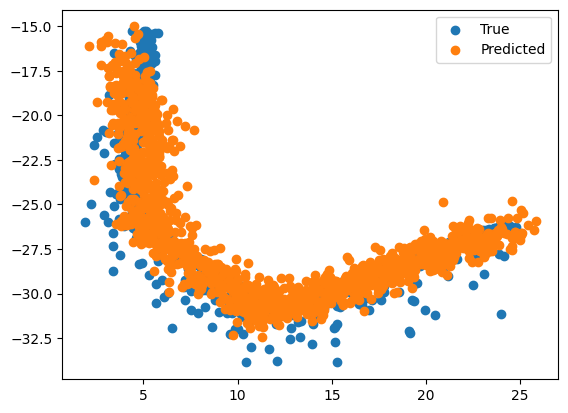

In [110]:
plt.scatter(y_train[:, 0], y_train[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = ELM.predict(x_train)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

5/5 [==============================] - 0s 2ms/step


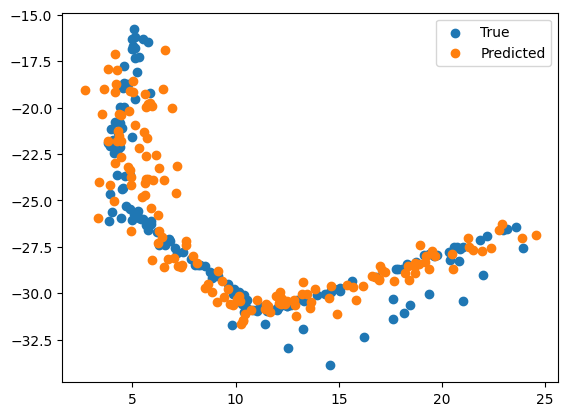

In [111]:
plt.scatter(y_test[:, 0], y_test[:, 1], label="True")
# pred = scaler.inverse_transform(pred)
pred = ELM.predict(x_test)
plt.scatter(pred[:, 0], pred[:, 1], label = "Predicted")
plt.legend()
plt.show()

In [168]:
mse_loss, mee_loss  = ELM.evaluate(x_train, y_train, verbose=0)
print(mse_loss)
print(mee_loss)

6.110070705413818
2.9254326820373535
